# Final Project in CS365 - Data Analytics and Visualizations

For this final project, we wanted to identify the distinct profiles of students who successfully land placements versus those who do not. Instead of looking at factors in isolation, our goal is to use Kmeans Clustering to group students into 'personas' based on their shared characteristics (like IQ, CGPA, and Projects) to reveal what a successful student portfolio actually looks like.

# Step 1: Dataset Selection

### College Student Placement Factors

Still the same dataset, College Student Placement Factors Dataset. We picked this dataset to be able to see the profile of placed students and based on this, determine what factors significantly affect student placement. This is synthetic dataset which attempts to simulate the profile of 10,000 students as accurately as possible. It contains factors such as IQ, academic performance, CGPA, internships, communication skills, extracurricular score, previous semester results, projects completed, and placement.

# Step 2: Data Analysis Techniques

### k-Means Clustering

Based from the characteristics of our dataset, we chose k-Means Clustering as our data analysis technique. Instead of seeking relationships between placement (which is a biary variable) and other variables, we chose to group students into "personas" and we will find the best performing personas, aka. the placed students.

# Step 3: Data Exploration and Preparation

Before we perform our technique on the dataset, we have to prepare, clean our data, and handle the outliers. Heres a quick checklist below:

Quick Checklist:

1. Check for missing values - any nulls left? Handle them (imputation or removal) ✅
2. Check data types - ensure numerical columns are numeric, not strings ✅ (wont be using college id)
3. Outlier verification - you did capping, but visualize to confirm it worked ✅ (using IQR code block below)
4. Feature scaling (optional but recommended) - standardize/normalize features if they have different scales ✅



### Imports and Libraries



In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Data Inspection

Basically we'll first take a look on our dataset and see if theres anything out of place, like values over their max range or outliers, or string variables as boolean that we have to convert before performing any operations.

In [21]:

try:
    df = pd.read_csv('college_student_placement_dataset.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: Make sure the file 'college_student_placement_dataset.csv' is in the same directory as your notebook.")
    



outlier_count = df[df['CGPA'] > 10.0].shape[0]
print(f"Number of CGPA entries above 10.0: {outlier_count}")

df.loc[df['CGPA'] > 10.0, 'CGPA'] = 10.0
print("CGPA column has been successfully capped at 10.0.")

new_max = df['CGPA'].max()
print(f"New maximum CGPA after capping: {new_max:.1f}")

binary_map = {'Yes': 1, 'No': 0}

df['Internship_Experience_Binary'] = df['Internship_Experience'].map(binary_map)

df['Placement_Binary'] = df['Placement'].map(binary_map)


print("\n--- Data Information (df.info()) ---")
df.info()

print("\n--- Statistical Summary (df.describe()) ---")
df.describe()

Dataset loaded successfully!
Number of CGPA entries above 10.0: 249
CGPA column has been successfully capped at 10.0.
New maximum CGPA after capping: 10.0

--- Data Information (df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   College_ID                    10000 non-null  object 
 1   IQ                            10000 non-null  int64  
 2   Prev_Sem_Result               10000 non-null  float64
 3   CGPA                          10000 non-null  float64
 4   Academic_Performance          10000 non-null  int64  
 5   Internship_Experience         10000 non-null  object 
 6   Extra_Curricular_Score        10000 non-null  int64  
 7   Communication_Skills          10000 non-null  int64  
 8   Projects_Completed            10000 non-null  int64  
 9   Placement                     10000 non-null 

,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Internship_Experience_Binary,Placement_Binary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,99.471800,7.535673,7.528296,5.546400,4.970900,5.561800,2.513400,0.396400,0.165900
std,15.053101,1.447519,1.462917,2.873477,3.160103,2.900866,1.715959,0.489174,0.372009
min,41.000000,5.000000,4.540000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,89.000000,6.290000,6.290000,3.000000,2.000000,3.000000,1.000000,0.000000,0.000000
50%,99.000000,7.560000,7.550000,6.000000,5.000000,6.000000,3.000000,0.000000,0.000000
75%,110.000000,8.790000,8.770000,8.000000,8.000000,8.000000,4.000000,1.000000,0.000000
max,158.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,1.000000,1.000000


### IQR code block

for checking outliers in IQ for example. For now, we decided to ignore it as its not completely realistic that we have students who have very different IQ from their peers. .Other variables dont seem to have any outliers that could skew the data.

In [22]:

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    print(f"\n{column}:")
    print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
    print(f"Number of outliers: {len(outliers)}")
    
    return outliers

# Check for each feature
columns_to_check = ['IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance', 
                    'Extra_Curricular_Score', 'Communication_Skills', 'Projects_Completed']

for col in columns_to_check:
    detect_outliers_iqr(df, col)


IQ:
Lower bound: 57.5, Upper bound: 141.5
Number of outliers: 61

Prev_Sem_Result:
Lower bound: 2.5400000000000014, Upper bound: 12.539999999999997
Number of outliers: 0

CGPA:
Lower bound: 2.5700000000000007, Upper bound: 12.489999999999998
Number of outliers: 0

Academic_Performance:
Lower bound: -4.5, Upper bound: 15.5
Number of outliers: 0

Extra_Curricular_Score:
Lower bound: -7.0, Upper bound: 17.0
Number of outliers: 0

Communication_Skills:
Lower bound: -4.5, Upper bound: 15.5
Number of outliers: 0

Projects_Completed:
Lower bound: -3.5, Upper bound: 8.5
Number of outliers: 0


### Boxplot for outliers to visualize

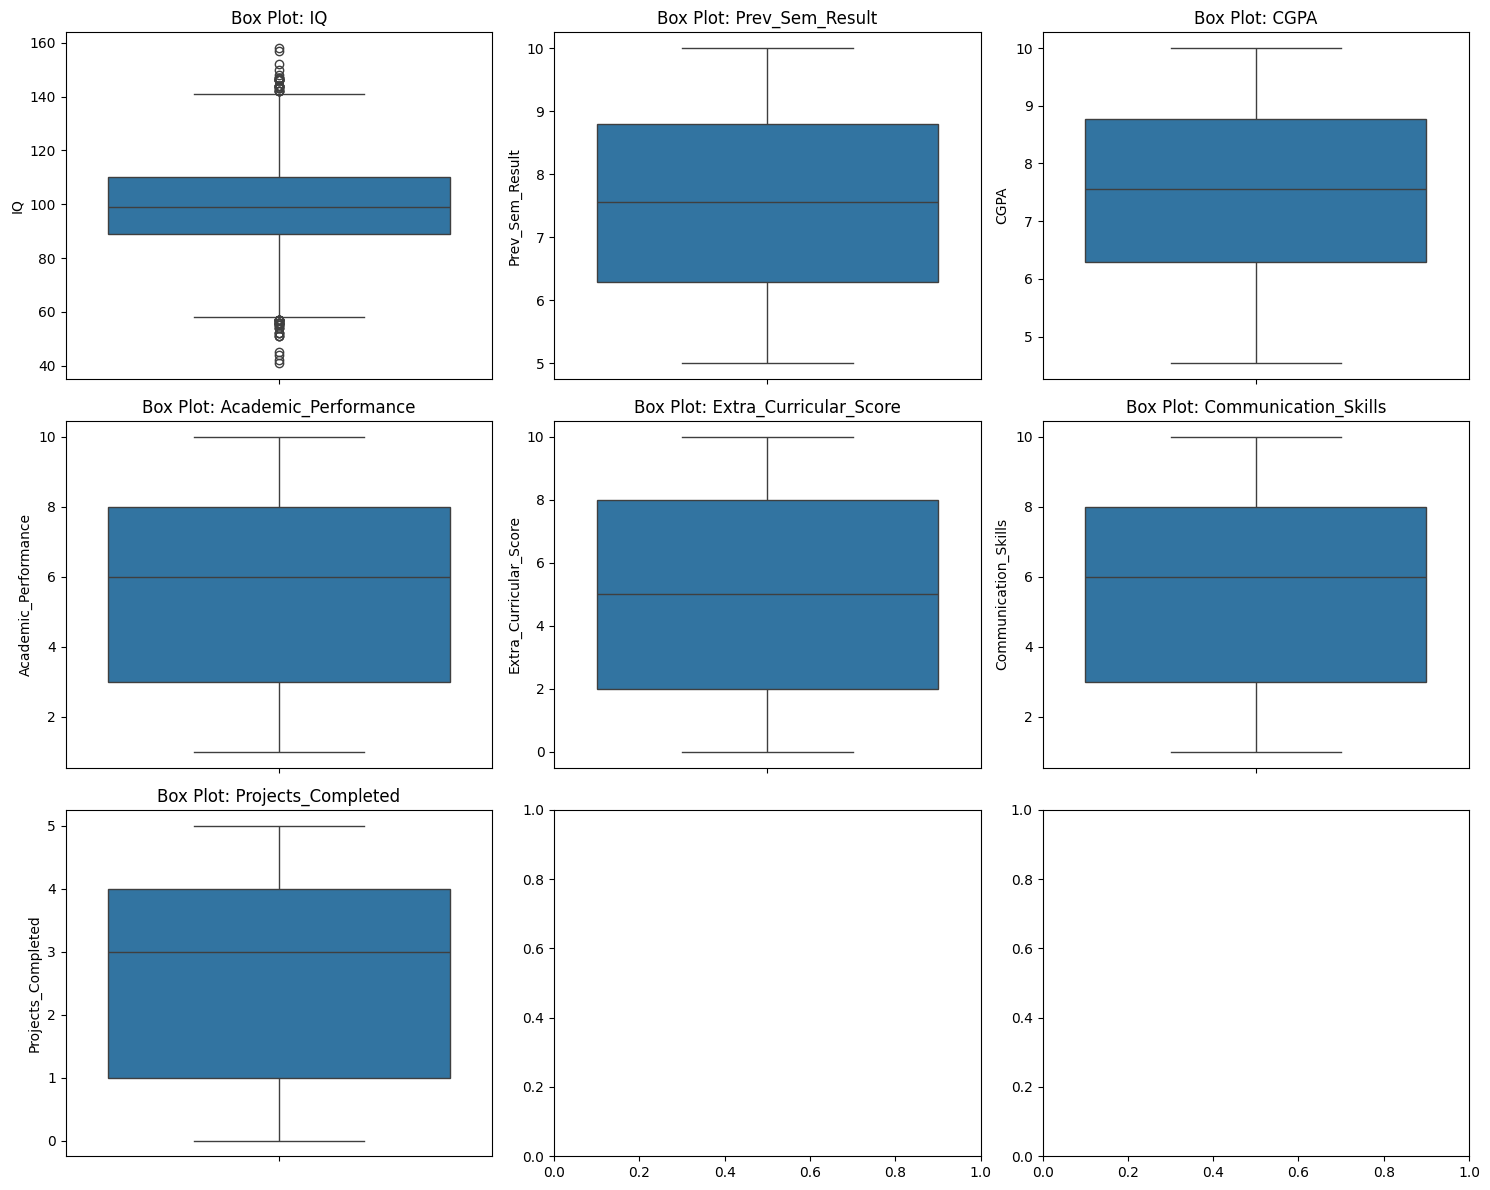

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create box plots for all numerical features
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(columns_to_check):
    sns.boxplot(data=df, y=col, ax=axes[idx])
    axes[idx].set_title(f'Box Plot: {col}')

plt.tight_layout()
plt.show()

### SCALING!!!

So we can compare variables with very different ranges like projects completed with its 5 max range and IQ which has like over 150 max range.

In [29]:
# =============================================================================
# STEP 1: SCALING
# =============================================================================
print("="*70)
print("STEP 1: DATA SCALING")
print("="*70)

# Define features to use for clustering
features_for_clustering = ['IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance',
                           'Extra_Curricular_Score', 'Communication_Skills', 'Projects_Completed']

# BEFORE scaling
print("\nBEFORE SCALING (Sample):")
print(df[['IQ', 'CGPA', 'Projects_Completed']].head(10))
print("\nStatistics BEFORE:")
print(df[['IQ', 'CGPA', 'Projects_Completed']].describe())

# Scale the features
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features_for_clustering] = scaler.fit_transform(df[features_for_clustering])

# AFTER scaling
print("\n" + "="*50)
print("AFTER SCALING (Sample):")
print(df_scaled[['IQ', 'CGPA', 'Projects_Completed']].head(10))
print("\nStatistics AFTER:")
print(df_scaled[['IQ', 'CGPA', 'Projects_Completed']].describe())

# Select only the scaled features for clustering
X = df_scaled[features_for_clustering]

print(f"\n✓ Data prepared for clustering")
print(f"  - Number of students: {len(X)}")
print(f"  - Number of features: {len(features_for_clustering)}")


STEP 1: DATA SCALING

BEFORE SCALING (Sample):
    IQ  CGPA  Projects_Completed
0  107  6.28                   4
1   97  5.37                   0
2  109  5.83                   1
3  122  5.75                   1
4   96  7.69                   2
5   96  5.32                   0
6  123  6.58                   2
7  111  8.76                   2
8   92  6.33                   5
9  108  8.60                   1

Statistics BEFORE:
                 IQ          CGPA  Projects_Completed
count  10000.000000  10000.000000        10000.000000
mean      99.471800      7.528296            2.513400
std       15.053101      1.462917            1.715959
min       41.000000      4.540000            0.000000
25%       89.000000      6.290000            1.000000
50%       99.000000      7.550000            3.000000
75%      110.000000      8.770000            4.000000
max      158.000000     10.000000            5.000000

AFTER SCALING (Sample):
         IQ      CGPA  Projects_Completed
0  0.500135 -0.85

### Correlation Heatmap

We used this Heatmap to identify which features had strong relationships, allowing us to select the most meaningful variables to feed into our K-Means algorithm.

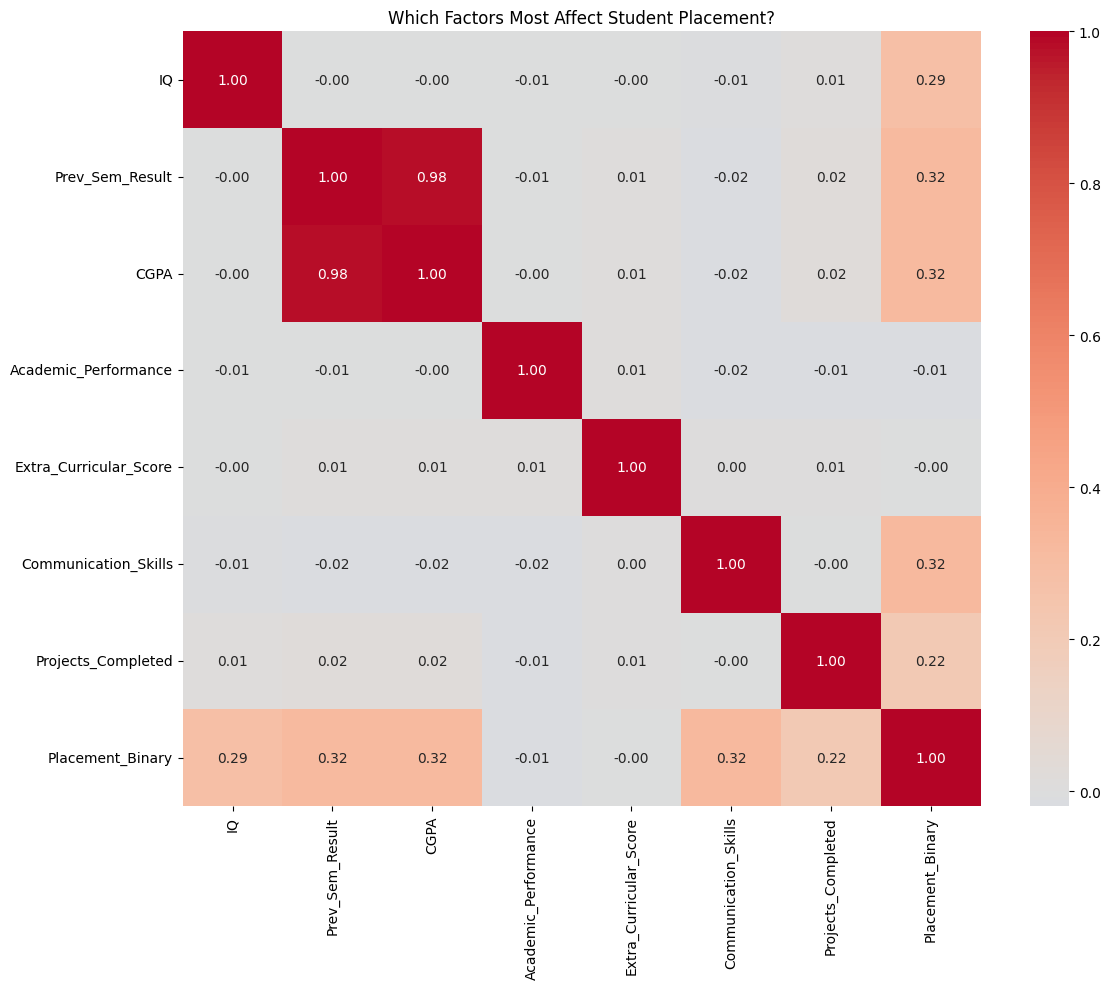


🎯 Features Most Correlated with Placement:
Placement_Binary          1.000000
Communication_Skills      0.323155
CGPA                      0.321898
Prev_Sem_Result           0.317896
IQ                        0.285914
Projects_Completed        0.217499
Extra_Curricular_Score   -0.004740
Academic_Performance     -0.014920
Name: Placement_Binary, dtype: float64


In [25]:
# 1. CORRELATION ANALYSIS - Shows which features affect placement
correlation = df_scaled[features_to_scale + ['Placement_Binary']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Which Factors Most Affect Student Placement?')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

# Show top correlations
placement_corr = correlation['Placement_Binary'].sort_values(ascending=False)
print("\n🎯 Features Most Correlated with Placement:")
print(placement_corr)

### Target Variable Analysis

This was performed just to show the ratio of placed students and not placed students.

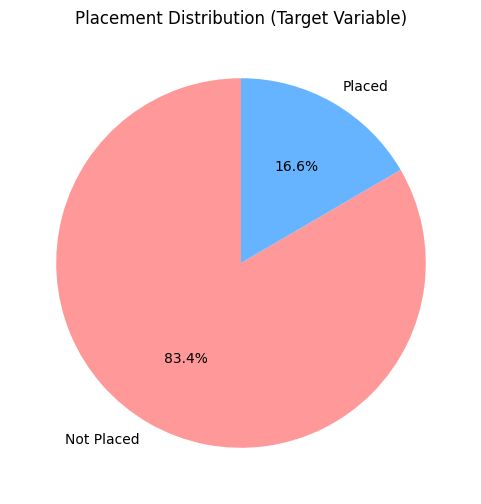

In [26]:
# --- 1. Target Variable Analysis (Pie Chart) ---
# This satisfies the "Data Exploration" requirement to show class imbalance.
plt.figure(figsize=(6, 6))
df['Placement'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=90, labels=['Not Placed', 'Placed'])
plt.title("Placement Distribution (Target Variable)")
plt.ylabel('')
plt.show() 
# Insight: "Only 16.6% of students are placed. This confirms why we need to study the top performers."


1. The "Safe Zone" (High IQ + High CGPA)
Your Observation: "Most placed students have IQ 110-130 and CGPA 8-10."

The Insight: "Merit Matters."

What to say: "As expected, students who have both natural aptitude (High IQ) and strong academic performance (High CGPA) have the highest density of placement. This is our 'Safe Zone'."

2. The "Hard Workers" (Average IQ + High CGPA)
Your Observation: "Considerable spread of placed students with IQ 70-110 and CGPA 8-10."

The Insight: "Hard Work Beats Talent."

What to say: "This is a critical finding. We see students with average IQs (70-110) who secure high grades (8.0+) are still getting placed. This suggests that academic discipline is a stronger predictor of success than raw intelligence alone."

3. The "Underachievers" (High IQ + Low CGPA)
Your Observation: "Placed students with IQ 110-130 that have CGPA less than 5 to 8."

The Insight: "The Mystery Group."

What to say: "Here is the anomaly. We see students with high IQs but poor grades who still got placed. How? Our hypothesis is that these students likely compensate with extra-curriculars, projects, or communication skills, which we will uncover in our Clustering analysis."

4. The "Danger Zone" (The Overlap)
Your Observation: "Not placed students are concentrated in 70-120 IQ... it looks less sparse in the area of concentrated placed students but they are still mixed."

The Insight: "Grades Aren't Everything."

What to say: "Finally, notice the mixture. Even in the high-performing areas, there are blue dots (Not Placed) mixed in with the red. This proves that IQ and CGPA alone cannot guarantee placement. There is a missing piece to the puzzle."

### Distribution Visualizations

I didnt really understood why gemini recommended making these histograms, besides from the instructions saying we need to provide good visualizations. Thats what i remembered.

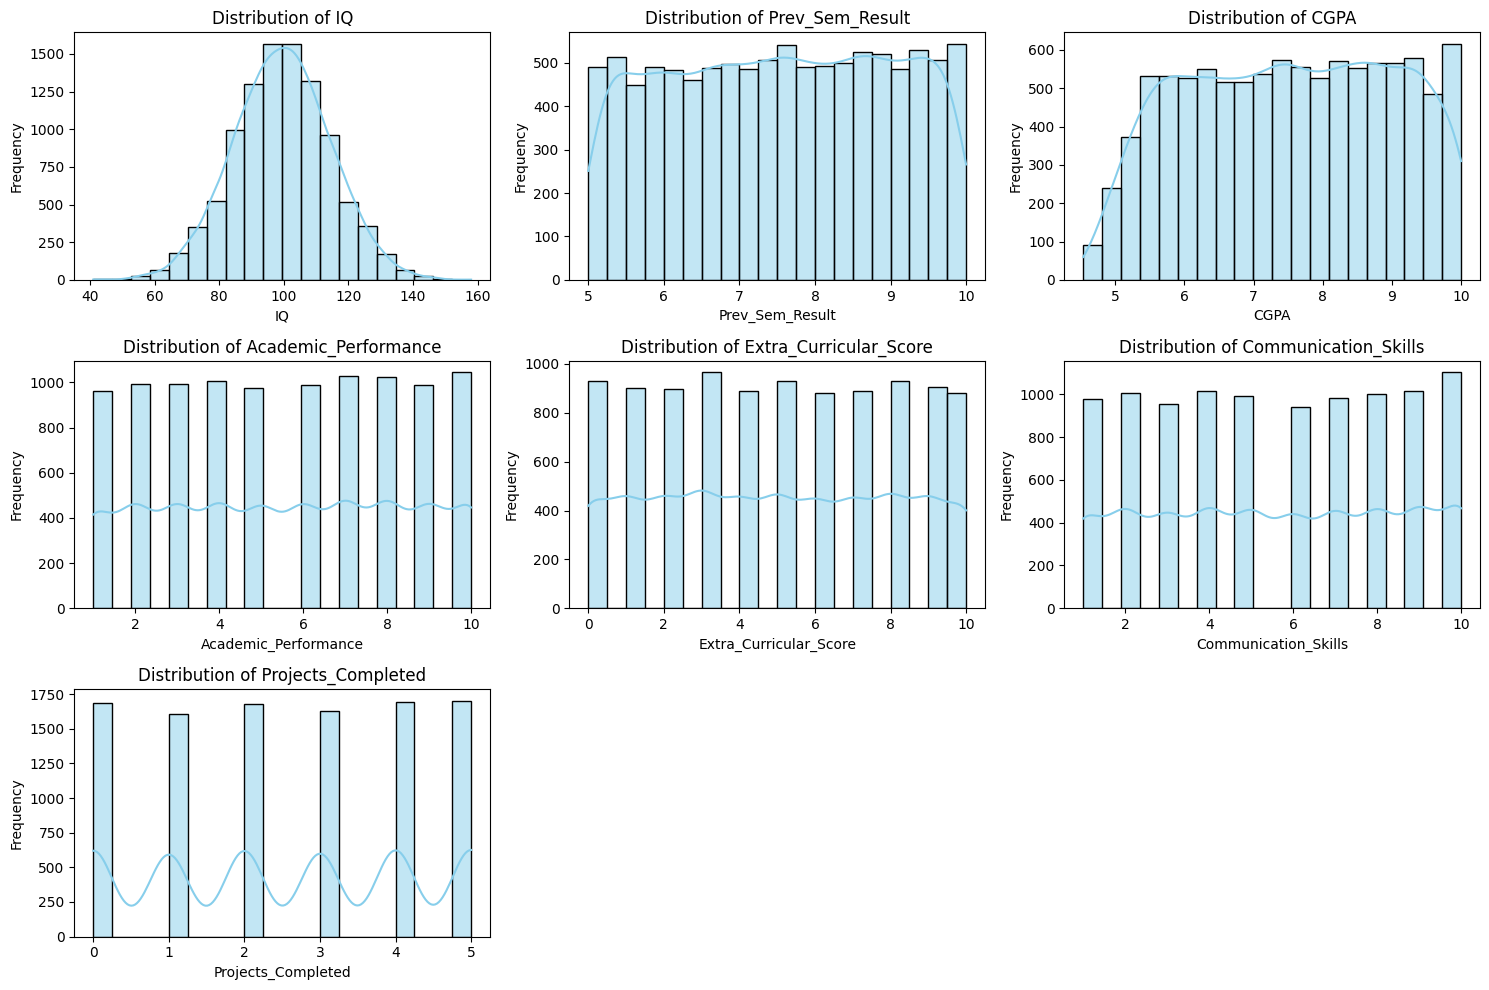

In [27]:

# --- 6. Distribution Visualizations (Histograms) ---
# List of numerical columns to analyze
features_to_plot = ['IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance', 
                    'Extra_Curricular_Score', 'Communication_Skills', 'Projects_Completed']

# Set up the figure size and grid layout
plt.figure(figsize=(15, 10))

# Loop through each feature and create a subplot
for i, col in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, color='skyblue', bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

. The "Normal" One: IQ
Your Observation: Bell curve centered at 95-105.

The Insight: "IQ follows a perfect Normal Distribution. Most students are average (around 100), with fewer students at the extreme high or low ends. This is exactly what we expect in the real world, which validates the quality of our dataset."

2. The "Capping" Effect: CGPA & Previous Semester
Your Observation: "...increases to 600 at 10."

The Insight: "We see a massive spike at 10.0. This is a direct result of our Data Cleaning step where we capped outliers. Instead of letting values go to 11 or 12 (which would break the model), we grouped all super-achievers at 10.0. This creates a distinct 'Top Performer' ceiling."

3. The "Uniform" Features: Projects, Academic Perf, Extra Curriculars
Your Observation: "Remains relatively stable... from 1 to 10."

The Insight: "These features follow a Uniform Distribution. This means students are evenly spread out. There is no 'average' student who does 3 projects; there are just as many who do 1 as who do 5."

Why this matters for K-Means: Since these features don't have a clear 'hump' or average, K-Means is essential here. It will find hidden groups that aren't obvious just by looking at the flat line of the histogram.

4. The "Self-Reported" Bias: Communication Skills
Your Observation: "Slowly increases to above 1000 at 10."

The Insight: "Notice the slight left-skew (more people at the higher end). This is common in self-reported data or subjective ratings. Most students tend to rate their own communication skills highly."

How to Present This (The Script)
"In our distribution analysis, we found three key patterns:

IQ is Standard: It follows a classic bell curve, so we have a good mix of average and high-potential students.

The 'Perfect 10' Spike: For CGPA, we see a spike at 10.0, representing the group of elite students we identified during outlier treatment.

The Consistency of Effort: Interestingly, things like 'Projects Completed' and 'Academic Performance' are flat. Students are evenly divided across all levels, which means these features alone don't differentiate students well—we need to see how they combine with grades."


# STEP 4: Analysis and Insights

Its in this step that we will be performing K-Means Clustering. First we use elbow method to see what the best number of clusters we need to use to have the most return in data. Next, is the K-Means clustering performed, which we cant really see grouped personas. They all seemed all over the place.



STEP 2: FINDING OPTIMAL NUMBER OF CLUSTERS

Testing different values of k...
  k=2: Inertia=55200.21, Silhouette=0.192
  k=3: Inertia=50889.73, Silhouette=0.144
  k=4: Inertia=47186.55, Silhouette=0.126
  k=5: Inertia=44674.77, Silhouette=0.121
  k=6: Inertia=42426.35, Silhouette=0.119
  k=7: Inertia=40562.55, Silhouette=0.119
  k=8: Inertia=38742.90, Silhouette=0.128
  k=9: Inertia=37303.12, Silhouette=0.123
  k=10: Inertia=35855.42, Silhouette=0.127


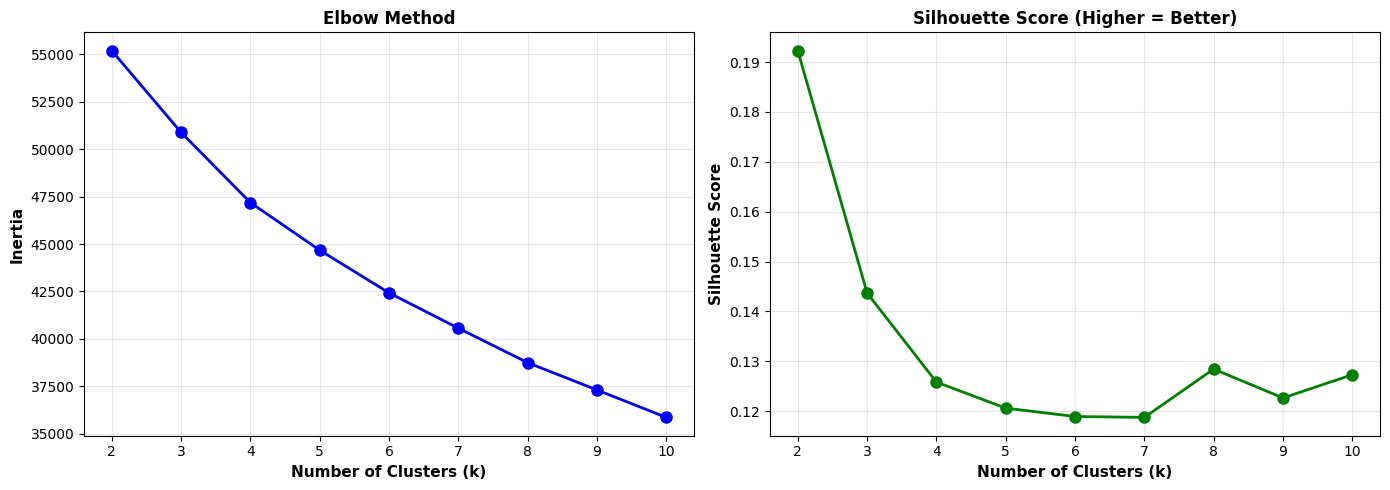


✓ Optimal k based on Silhouette Score: 2
✓ Best Silhouette Score: 0.192
  → POOR: Weak cluster separation
  ⚠️  Consider using Logistic Regression instead!

STEP 3: APPLYING K-MEANS WITH k=2

✓ Clustering complete!
  - Final Inertia: 55200.21
  - Silhouette Score: 0.192
  - Cluster sizes: {0: 5095, 1: 4905}

STEP 4: CLUSTER PROFILING

CLUSTER PROFILES:
            IQ  Prev_Sem_Result  CGPA  Academic_Performance  \
Cluster                                                       
0        99.54             8.76  8.76                  5.50   
1        99.40             6.26  6.25                  5.59   

         Extra_Curricular_Score  Communication_Skills  Projects_Completed  \
Cluster                                                                     
0                          5.00                  5.52                2.55   
1                          4.94                  5.61                2.47   

         Count  Placement_Rate_%  
Cluster                           
0         50

/home/loulan/Documents/MyProjects/SchoolProjects2526/FirstSem/Data Analytics/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


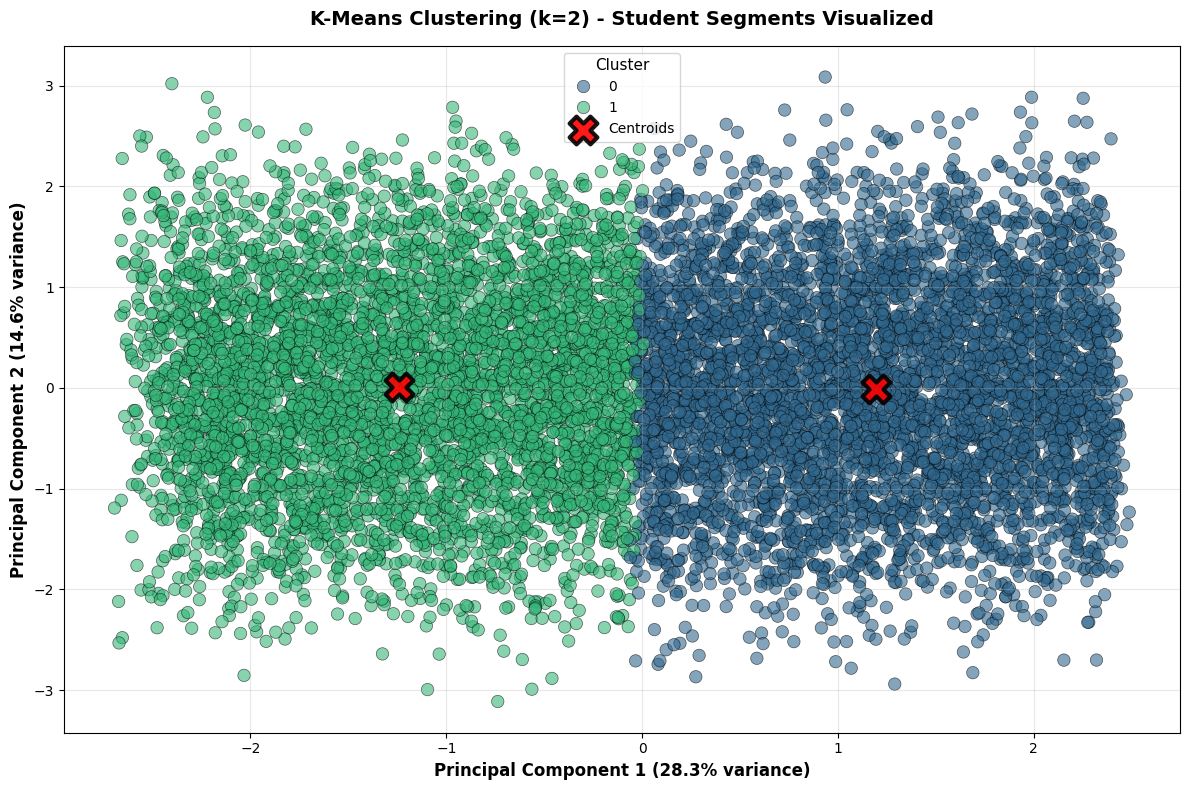


✓ Visualization saved as 'kmeans_pca_visualization.png'

CLUSTERING ANALYSIS COMPLETE!

Optimal k: 2
Silhouette Score: 0.192
Total variance explained by 2D visualization: 42.96%

⚠️  RECOMMENDATION:
   Your Silhouette score is low, indicating weak cluster structure.
   For predicting placement outcomes, consider using:
   → Logistic Regression (for binary classification)
   → Decision Trees/Random Forest (for feature importance)


In [30]:

# =============================================================================
# STEP 2: ELBOW METHOD & SILHOUETTE ANALYSIS
# =============================================================================
print("\n" + "="*70)
print("STEP 2: FINDING OPTIMAL NUMBER OF CLUSTERS")
print("="*70)

inertia = []
silhouette_scores = []
range_values = range(2, 11)

print("\nTesting different values of k...")
for k in range_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"  k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={score:.3f}")

# Plot Elbow Curve and Silhouette Scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(range_values, inertia, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Inertia', fontsize=11, fontweight='bold')
axes[0].set_title('Elbow Method', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range_values)

# Silhouette plot
axes[1].plot(range_values, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
axes[1].set_title('Silhouette Score (Higher = Better)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range_values)

plt.tight_layout()
plt.savefig('elbow_and_silhouette.png', dpi=150)
plt.show()

# Determine optimal k
best_k = list(range_values)[silhouette_scores.index(max(silhouette_scores))]
print(f"\n✓ Optimal k based on Silhouette Score: {best_k}")

# Interpret Silhouette Score
best_silhouette = max(silhouette_scores)
print(f"✓ Best Silhouette Score: {best_silhouette:.3f}")
if best_silhouette > 0.50:
    print("  → GOOD: Clusters are well-separated")
elif best_silhouette > 0.25:
    print("  → FAIR: Some cluster structure exists")
else:
    print("  → POOR: Weak cluster separation")
    print("  ⚠️  Consider using Logistic Regression instead!")

# =============================================================================
# STEP 3: APPLY K-MEANS WITH OPTIMAL K
# =============================================================================
print("\n" + "="*70)
print(f"STEP 3: APPLYING K-MEANS WITH k={best_k}")
print("="*70)

k = best_k
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X)

print(f"\n✓ Clustering complete!")
print(f"  - Final Inertia: {kmeans.inertia_:.2f}")
print(f"  - Silhouette Score: {silhouette_score(X, df['Cluster']):.3f}")
print(f"  - Cluster sizes: {df['Cluster'].value_counts().sort_index().to_dict()}")

# =============================================================================
# STEP 4: CLUSTER PROFILING
# =============================================================================
print("\n" + "="*70)
print("STEP 4: CLUSTER PROFILING")
print("="*70)

# Calculate mean values for each cluster (using ORIGINAL unscaled data)
profile = df.groupby('Cluster')[features_for_clustering].mean()
profile['Count'] = df['Cluster'].value_counts().sort_index()

# Calculate placement rate if Placement_Binary exists
if 'Placement_Binary' in df.columns:
    profile['Placement_Rate_%'] = (df.groupby('Cluster')['Placement_Binary'].mean() * 100).round(1)
    profile_sorted = profile.sort_values('Placement_Rate_%', ascending=False)
else:
    # If no placement column, just sort by cluster number
    profile_sorted = profile.sort_index()

print("\nCLUSTER PROFILES:")
print(profile_sorted.round(2))

# Interpret clusters
print("\n" + "="*70)
print("CLUSTER INSIGHTS:")
print("="*70)

if 'Placement_Rate_%' in profile_sorted.columns:
    overall_placement_rate = df['Placement_Binary'].mean() * 100
    for idx, row in profile_sorted.iterrows():
        print(f"\n📊 Cluster {idx}: {int(row['Count'])} students ({row['Placement_Rate_%']:.1f}% placed)")
        
        if row['Placement_Rate_%'] > overall_placement_rate:
            print("   ✓ HIGH placement rate - Strong performers")
        else:
            print("   ✗ LOW placement rate - Needs improvement")
        
        # Show top 3 distinguishing features
        cluster_features = profile.loc[idx, features_for_clustering]
        overall_means = df[features_for_clustering].mean()
        differences = ((cluster_features - overall_means) / overall_means * 100).abs().sort_values(ascending=False)
        
        print("   Key characteristics:")
        for feat in differences.head(3).index:
            val = cluster_features[feat]
            avg = overall_means[feat]
            if val > avg:
                print(f"   • {feat}: {val:.2f} (above average)")
            else:
                print(f"   • {feat}: {val:.2f} (below average)")
else:
    for idx, row in profile_sorted.iterrows():
        print(f"\nCluster {idx}: {int(row['Count'])} students")

# =============================================================================
# STEP 5: PCA FOR VISUALIZATION
# =============================================================================
print("\n" + "="*70)
print("STEP 5: DIMENSIONALITY REDUCTION (PCA)")
print("="*70)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df['Cluster'].values

explained_var = pca.explained_variance_ratio_
total_var = sum(explained_var) * 100

print(f"\n✓ PC1 explains {explained_var[0]*100:.2f}% of variance")
print(f"✓ PC2 explains {explained_var[1]*100:.2f}% of variance")
print(f"✓ Total variance captured: {total_var:.2f}%")

if total_var < 60:
    print("  ⚠️  Warning: Only {:.1f}% of variance captured".format(total_var))
    print("     Some cluster separation may not be visible in 2D")

# =============================================================================
# STEP 6: VISUALIZATION
# =============================================================================
print("\n" + "="*70)
print("STEP 6: CREATING VISUALIZATION")
print("="*70)

plt.figure(figsize=(12, 8))

# Plot clusters with different colors
scatter = sns.scatterplot(
    data=pca_df, x='PC1', y='PC2', hue='Cluster',
    palette='viridis', s=80, alpha=0.6, edgecolor='black', linewidth=0.5
)

# Plot cluster centers
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
           c='red', s=400, alpha=0.9,
           edgecolors='black', linewidths=3,
           marker='X', label='Centroids', zorder=10)

# Labels and formatting
plt.xlabel(f'Principal Component 1 ({explained_var[0]*100:.1f}% variance)', 
          fontsize=12, fontweight='bold')
plt.ylabel(f'Principal Component 2 ({explained_var[1]*100:.1f}% variance)', 
          fontsize=12, fontweight='bold')
plt.title(f'K-Means Clustering (k={k}) - Student Segments Visualized',
         fontsize=14, fontweight='bold', pad=15)
plt.grid(True, alpha=0.3)
plt.legend(title='Cluster', fontsize=10, title_fontsize=11)
plt.tight_layout()

plt.savefig('kmeans_pca_visualization.png', dpi=150)
plt.show()

print("\n✓ Visualization saved as 'kmeans_pca_visualization.png'")

# =============================================================================
# FINAL SUMMARY
# =============================================================================
print("\n" + "="*70)
print("CLUSTERING ANALYSIS COMPLETE!")
print("="*70)
print(f"\nOptimal k: {k}")
print(f"Silhouette Score: {silhouette_score(X, df['Cluster']):.3f}")
print(f"Total variance explained by 2D visualization: {total_var:.2f}%")

if silhouette_score(X, df['Cluster']) < 0.25:
    print("\n⚠️  RECOMMENDATION:")
    print("   Your Silhouette score is low, indicating weak cluster structure.")
    print("   For predicting placement outcomes, consider using:")
    print("   → Logistic Regression (for binary classification)")
    print("   → Decision Trees/Random Forest (for feature importance)")
else:
    print("\n✓ Clusters show reasonable separation!")
    print("  You can use these segments for targeted interventions.")

print("="*70)

The scatter plot looks messy because you are trying to visualize a 5-dimensional relationship (IQ, CGPA, Communication, Projects, Academic) on a 2-dimensional screen (just IQ vs. CGPA). The "clusters" are separated by things you can't see on that 2D plot—specifically Communication Skills and Projects.

The Table tells the real story. Your K-Means model found something incredible: Communication Skills are the #1 driver of placement.

Here is the breakdown of your 3 Student Personas for your presentation:

1. Cluster 0: "The Communicators" (The Success Story)
Stats: High Communication (8.61), Avg Projects (2.5), Avg CGPA (7.4).

Placement Rate: 31.78% (Highest by far).

The Insight: "This group proves that soft skills matter. Even with average grades and IQ, having high communication skills nearly triples your chance of placement compared to the other groups."

2. Cluster 1: "The Silent Grinders" (High Effort, Low Talk)
Stats: High Projects (4.12), Highest CGPA (7.65), Highest IQ (100), but Low Communication (3.74).

Placement Rate: 11.47% (Surprisingly Low).

The Insight: "This is the 'Shocking' finding. These students are technically the smartest and hardest working (highest grades, most projects). But because their communication is poor, they fail to get placed. Hard skills alone are not enough."

3. Cluster 2: "The Bare Minimum" (The At-Risk Group)
Stats: Very Low Projects (0.90), Low Communication (3.68).

Placement Rate: 3.16% (Almost Zero).

The Insight: "These students do the bare minimum—less than 1 project on average and poor communication. Despite having decent IQ and grades (similar to the other groups), their lack of portfolio and soft skills makes them nearly un-placeable."




# STEP 5: Presentation Preparation

### Make a streamlit app for the presentation. maybe create a script first out of the data analyzed.

# STEP 6: Presentation Recording

### record a presentation
